# **Fastai và Weights & Biases**
> WandB là ML platform được sử dụng để track các thông tin của model, giúp chúng ta có thể lưu lại thông số của nhiều phép thử khác nhau, so sánh kết quả, đánh giá model và lựa chọn model phù hợp nhất.
>
> Chúng ta sẽ thử nghiệm với các model đã được sử dụng trong repository: [swift_swallow_classification](https://github.com/ddpham/swift_swallow_classification)

In [ ]:
from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.metrics import F1Score
import wandb

# Tạo dữ liệu

In [ ]:
# Tạo path:
path = Path('../data/train/')
path.ls()

(#2) [Path('../data/train/swift'),Path('../data/train/swallow')]

In [ ]:
# Tạo hàm tạo dữ liệu:
def get_dls(bs=32, size=224):
    '''Hàm khởi tạo datablocks và dataloaders với biến batch_size và size'''
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock)
        , get_items=get_image_files
        , get_y=parent_label
        , item_tfms=Resize(460)
        , batch_tfms=[*aug_transforms(size=size, min_scale=.75), Normalize.from_stats(*imagenet_stats)]
    )
    return dblock.dataloaders(path, bs=bs)

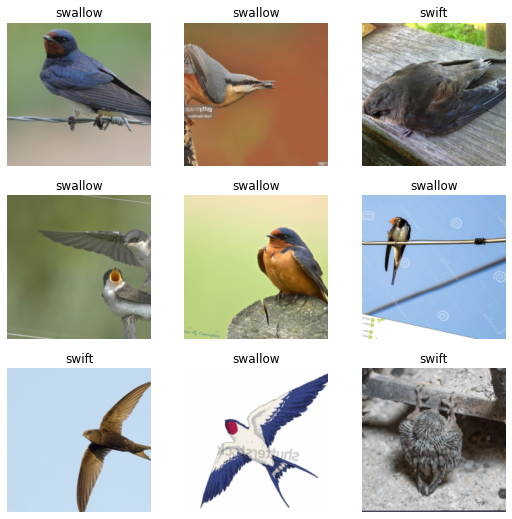

In [ ]:
# Tạo và kiểm tra dữ liệu:
dls = get_dls()
dls.show_batch(max_n=9, ncols=3)

# Base Model

Chúng ta sẽ tạo base model trước khi bắt đầu các bước biến đổi dữ liệu khác nhau để cải thiện model. Chúng ta sẽ sử dụng xresnet50 đã được pretrained làm base model.

## Khởi động wandb
> Trước khi bắt đầu bất kỳ model nào, chúng ta cần phải init project để tạo 1 lần run mới, như vậy, trong project trên Weights & Biases, chúng ta sẽ thấy xuất hiện nhiều run khác nhau. Nếu bạn quên ko fishi và init lại, thì rất nhiều model sẽ bị ghi đè lên nhau, khiến việc phân loại các model là không thể.
>
> Để bắt đầu wandb, chúng ta sử dụng `wandb.init()`
>
> Để dừng, chúng ta sử dụng `wandb.finish()`

In [ ]:
PROJECT_NAME = 'swift-swallow-classification'
ENTITY_NAME = 'ddpham'

> Với câu lệnh init của wandb, bạn sẽ được hỏi API token của mình, bản chỉ cần copy và paste vào dưới là được.

In [ ]:
# Bắt đầu với model mới:
wandb.init(project=PROJECT_NAME, entity=ENTITY_NAME)

wandb: Currently logged in as: ddpham (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


SuggestedLRs(valley=0.0002754228771664202)


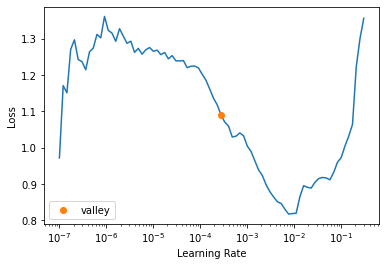

In [ ]:
# Tạo learner,sử dụng resnet50 đã được học:
FNAME = 'fastai_base'
learn = cnn_learner(dls, resnet50, pretrained=True, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score()])

# Tìm lr tốt nhất để học:
lr_valley = learn.lr_find()
print(lr_valley)

In [ ]:
# Chỉ log lại thông tin khi sử dụng 
learn.fit_one_cycle(10, lr_max=lr_valley, cbs=[WandbCallback(), SaveModelCallback(fname=FNAME)])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.120825,0.475833,0.774648,0.771429,00:13
1,0.816420,0.244382,0.922535,0.929032,00:11
2,0.648976,0.199212,0.922535,0.928105,00:13
3,0.546088,0.202354,0.915493,0.923077,00:12
4,0.453626,0.212295,0.908451,0.916129,00:12
5,0.371833,0.228187,0.894366,0.904459,00:11
6,0.322541,0.201769,0.915493,0.923077,00:11
7,0.283880,0.167254,0.915493,0.924051,00:11
8,0.270172,0.194799,0.915493,0.923077,00:12
9,0.250715,0.188777,0.915493,0.923077,00:12


Better model found at epoch 0 with valid_loss value: 0.47583314776420593.
Better model found at epoch 1 with valid_loss value: 0.24438239634037018.
Better model found at epoch 2 with valid_loss value: 0.1992119997739792.
Better model found at epoch 7 with valid_loss value: 0.16725356876850128.


__NOTE:__
Chúng ta có thể dừng wandb ở đây để ghi tiếp model khác.

In [ ]:
%timeit wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


The slowest run took 9.33 times longer than the fastest. This could mean that an intermediate result is being cached.
2.1 µs ± 2.59 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Progressive Resize

> Progressive resize (tăng kích cỡ ảnh dần dần) là phương pháp được sử dụng trong DL cho hình ảnh khá phổ biến, trong đó, ảnh sẽ được tăng kích cỡ (size) theo nhiều lần train. Với size ảnh nhỏ, model sẽ học nhanh hơn, còn size lớn hơn, model sẽ được chính xác hơn.

Chúng ta sẽ áp dụng chiến thuật này với 3 kích cỡ khác nhau: 128, 224, 256.
Với `progressive resize`, chúng ta sẽ để callback vào learner để có thể chạy toàn bộ quá trình (bao gồm cả `lr_find`), còn nếu chúng ta chỉ muốn track lại phần fit thì sẽ phải để callback ở phần `fit_one_cycle` (như cách chúng ta làm dưới đây)

In [ ]:
# Bắt đầu với model mới:
wandb.init(project=PROJECT_NAME, entity=ENTITY_NAME)

wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Size = 128

In [ ]:
## Bắt đầu vs 128:
dls = get_dls(128, 128) # bs=128, size=128
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score()])

SuggestedLRs(valley=0.0004786300996784121)
WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.141870,1.306422,0.605634,0.548387,00:11
1,0.927707,0.947366,0.816901,0.831169,00:09
2,0.764510,0.589046,0.852113,0.867925,00:11
3,0.666583,0.385297,0.866197,0.884848,00:09
4,0.603005,0.348860,0.866197,0.886228,00:09


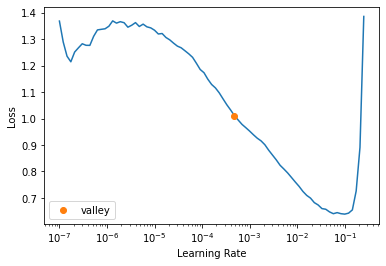

In [ ]:
lr_valley = learn.lr_find()
print(lr_valley)
learn.fit_one_cycle(5, lr_max=lr_valley, cbs=[WandbCallback()])

__NOTE:__
chúng ta có thể thấy vói size=128, kết quả trả về cho accuracy và F1score thấp hơn so với size=224 của base model ở trên. Chúng ta sẽ tiếp tục thử nghiệm với size lớn hơn.

## Size = 224

SuggestedLRs(valley=0.0012022644514217973)
WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.455642,0.239436,0.929577,0.933333,00:13
1,0.393340,0.230892,0.943662,0.949367,00:12
2,0.324473,0.349425,0.908451,0.919255,00:11
3,0.299808,0.286605,0.929577,0.935897,00:12
4,0.264273,0.423866,0.887324,0.894737,00:14
5,0.226637,0.310521,0.922535,0.929032,00:11
6,0.195522,0.258730,0.943662,0.950000,00:12
7,0.167382,0.265910,0.943662,0.949367,00:11
8,0.148971,0.269533,0.943662,0.949367,00:11
9,0.137325,0.267664,0.943662,0.949367,00:12


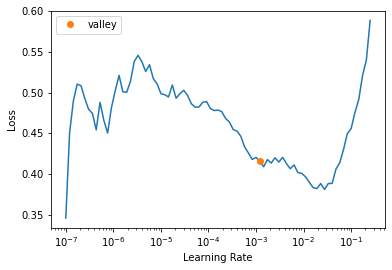

In [ ]:
## Update size của dữ liệu
learn.dls = get_dls(64, 224) # bs=64, size=224
lr_valley = learn.lr_find()
print(lr_valley)
learn.fit_one_cycle(10, lr_max=lr_valley, cbs=[WandbCallback()])

__NOTE:__ 
Trong quá trình train, chúng ta lưu ý tránh để lỗi typo trong code, có thể ảnh hưởng đến kết quả train! Vì kết quả của chúng ta là dạng lũy kế nên các lỗi sai không đáng có (lr_find, fit_one_cycle) có thể ảnh hưởng đến weights của model.

## Size = 256

SuggestedLRs(valley=0.0006918309954926372)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.195161,0.054179,0.985915,0.988764,00:17
1,0.180573,0.043638,0.985915,0.988764,00:13
2,0.150808,0.069310,0.992958,0.994350,00:13
3,0.140487,0.043582,0.985915,0.988764,00:13
4,0.151984,0.050676,0.985915,0.988764,00:13
5,0.146522,0.037213,0.985915,0.988764,00:14
6,0.138428,0.055230,0.985915,0.988764,00:13
7,0.122078,0.025484,0.992958,0.994350,00:13
8,0.104347,0.036379,0.992958,0.994350,00:13
9,0.090842,0.031664,0.985915,0.988764,00:13


Better model found at epoch 0 with valid_loss value: 0.054179102182388306.
Better model found at epoch 1 with valid_loss value: 0.04363829642534256.
Better model found at epoch 3 with valid_loss value: 0.04358212277293205.
Better model found at epoch 5 with valid_loss value: 0.03721310570836067.
Better model found at epoch 7 with valid_loss value: 0.02548377588391304.
Better model found at epoch 14 with valid_loss value: 0.024408893659710884.


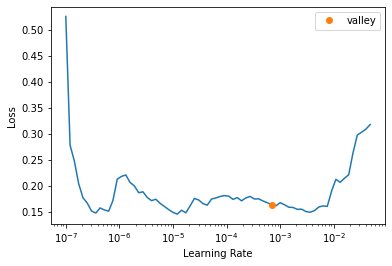

In [ ]:
## Update size của dữ liệu
learn.dls = get_dls(32, 256) # bs=32, size=256
lr_valley = learn.lr_find()
print(lr_valley)

# Ở đây chúng ta sẽ bổ sung thêm SaveModelCallback để lưu model tốt nhất:
learn.fit_one_cycle(15, lr_max=lr_valley, cbs=[WandbCallback(), SaveModelCallback(fname='fastai_pr-1')])

__NOTE:__
Kết quả của model này tốt hơn rất nhiều so với base model. Hãy dừng wandb lại để thử lại một lần nữa với số lượng epochs khác.

In [ ]:
%timeit wandb.finish()

wandb: Network error resolved after 0:00:11.506987, resuming normal operation.


epoch,30
train_loss,0.04925
raw_loss,0.00458
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.94999
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
train_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▃▄▄▄▂▂▂▁▁▂▂▃▁▁▃▁▁▁▄▂▁▃▂▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▃▃▁▃▇█▇▆▄▂▁▁▁▂▃▃▄▅▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,▃▃█▆▂▁▂▃▅▇███▇▅▄▃▂▁▁▁▁▂▂▂▃▃▄▄▄▅▆▆▆▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▃▃▁▃▇█▇▆▄▂▁▁▁▂▃▃▄▅▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁


The slowest run took 10.50 times longer than the fastest. This could mean that an intermediate result is being cached.
514 ns ± 651 ns per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Thử lại
> giờ chúng ta sẽ thử lại các bước của PR và thay callback vào model:

In [ ]:
# Khởi động lại wandb:
wandb.init(project=PROJECT_NAME, entity=ENTITY_NAME)

wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


SuggestedLRs(valley=0.0008317637839354575)
WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.212008,0.720361,0.760563,0.716667,00:10
1,0.895248,0.260960,0.929577,0.931507,00:11
2,0.729716,0.246424,0.922535,0.925170,00:10
3,0.627634,0.258716,0.915493,0.918919,00:10


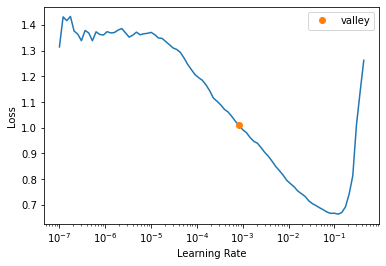

In [ ]:
dls = get_dls(128, 128)
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score()])
lr_valley = learn.lr_find()
print(lr_valley)
learn.fit_one_cycle(4, lr_max=lr_valley, cbs=[WandbCallback()])

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.391698,0.324330,0.887324,0.896104,00:12
1,0.358373,0.302684,0.929577,0.936709,00:11
2,0.317285,0.255688,0.929577,0.937500,00:12
3,0.272673,0.364827,0.901408,0.910256,00:12
4,0.241371,0.358831,0.943662,0.950000,00:13
5,0.217598,0.343469,0.929577,0.937500,00:11
6,0.187582,0.318278,0.922535,0.931677,00:12
7,0.174417,0.303579,0.929577,0.938272,00:11


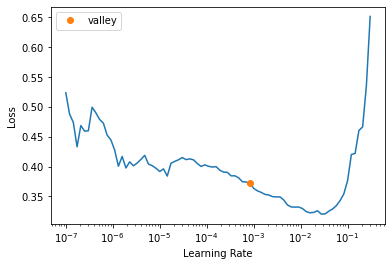

In [ ]:
learn.dls = get_dls(64, 224)
lr_valley = learn.lr_find()
learn.fit_one_cycle(8, lr_max=lr_valley, cbs=[WandbCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.228059,0.073742,0.971831,0.972603,00:13
1,0.177802,0.065087,0.985915,0.986301,00:12
2,0.152182,0.125756,0.971831,0.972973,00:13
3,0.138075,0.186476,0.943662,0.946667,00:12
4,0.135210,0.152046,0.971831,0.972973,00:13
5,0.122713,0.123618,0.957747,0.960000,00:13
6,0.124277,0.128036,0.964789,0.966443,00:13
7,0.103273,0.112924,0.971831,0.972973,00:14
8,0.100001,0.106683,0.971831,0.972973,00:13
9,0.085682,0.107371,0.971831,0.972973,00:12


Better model found at epoch 0 with valid_loss value: 0.07374225556850433.
Better model found at epoch 1 with valid_loss value: 0.06508663296699524.


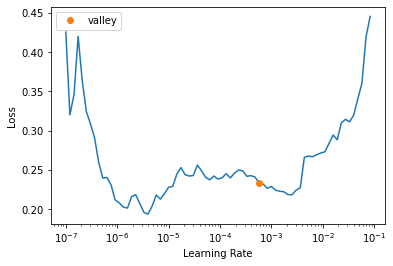

In [ ]:
learn.dls = get_dls(32, 256)
lr_valley = learn.lr_find()
learn.fit_one_cycle(12, lr_max=lr_valley, cbs=[WandbCallback(), SaveModelCallback()])

__NOTE:__
bạn thấy đó, kết quả thật sự tuyệt vời! Tuy nhiên, chúng ta đã có thể đạt kết quả tốt hơn chỉ với 5 epochs cho size lớn này.
Chúng ta hay lưu lại kết quả này:

In [ ]:
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


# MixUp

> MixUp cũng là một trong nhưng phương pháp sửa ảnh khá thú vị mà chúng ta có thể sử dụng. Ý tưởng của phương pháp này là chúng ta sẽ tạo ra thêm các bức ảnh là sự kết hợp giữa 2 ảnh bất kỳ nào đó với 1 tỷ lệ nhất định, ví dụ 70% chim Yến, 30% chim Yén. Việc này cũng sẽ khiến cho khả năng dự đoán của model sẽ khó hơn. Ngoài ra, kết quả dự đoán cuối cùng sẽ không phải là chim Yến (70%) mà phải là 70% chim Yến, 30% chim Yén. 

Chúng ta hay cùng đi qua ví dụ để hiểu nó hơn:

In [ ]:
wandb.init(project=PROJECT_NAME, entity=ENTITY_NAME)

In [ ]:
from fastai.callback import mixup
mixup_ = mixup.MixUp(alpha=0.3)

In [ ]:
dls = get_dls(32, 224)
model = resnet50(pretrained=True)

SuggestedLRs(valley=0.0008317637839354575)


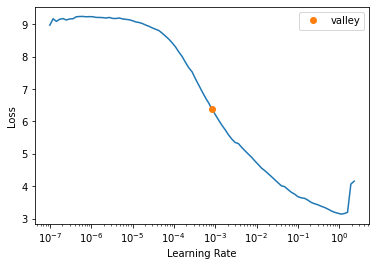

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score(average='macro')])
lr_valley = learn.lr_find()
print(lr_valley)

In [ ]:
learn.fit_one_cycle(80, lr_max=lr_valley, cbs=[mixup_, WandbCallback(), SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,7.273678,3.358464,0.471831,0.021104,00:14
1,5.314782,2.016199,0.739437,0.126995,00:15
2,3.745791,0.656318,0.901408,0.453485,00:14
3,2.631241,0.367791,0.908451,0.907418,00:14
4,1.907070,0.411455,0.873239,0.588745,00:15
5,1.398867,0.337388,0.894366,0.894361,00:13
6,1.053741,0.247122,0.922535,0.921409,00:14
7,0.815766,0.420483,0.880282,0.880228,00:16
8,0.645264,0.216525,0.936620,0.936237,00:14
9,0.539990,0.347668,0.915493,0.915342,00:12


WandbCallback was not able to get prediction samples -> list index out of range
Better model found at epoch 0 with valid_loss value: 3.358464002609253.
Better model found at epoch 1 with valid_loss value: 2.0161991119384766.
Better model found at epoch 2 with valid_loss value: 0.6563183665275574.
Better model found at epoch 3 with valid_loss value: 0.36779096722602844.
Better model found at epoch 5 with valid_loss value: 0.3373876214027405.
Better model found at epoch 6 with valid_loss value: 0.24712197482585907.
Better model found at epoch 8 with valid_loss value: 0.2165246307849884.
Better model found at epoch 56 with valid_loss value: 0.21309809386730194.
Better model found at epoch 60 with valid_loss value: 0.20840239524841309.
Better model found at epoch 72 with valid_loss value: 0.20608125627040863.


In [ ]:
wandb.finish()

epoch,80
train_loss,0.19322
raw_loss,0.1714
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
_runtime,1254
_timestamp,1631535281
_step,1359


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


# Label Smooth
> Label smooth có sự tương đồng với MixUp. Chúng ta tạo ra dữ liệu được sửa đổi thông qua việc gộp các ảnh với nhau như cách làm của mixup, hoặc có thể sửa label với bằng giá trị tương đối từ 0-1 thay vì chỉ có thể là 0 hoặc 1. Việc này sẽ giúp cho model học tốt hơn thay vì phải cố gắng để học đúng được giá trị tuyệt đối là 1. c

In [ ]:
wandb.init(project=PROJECT_NAME, entity=ENTITY_NAME)

wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


SuggestedLRs(valley=0.0008317637839354575)


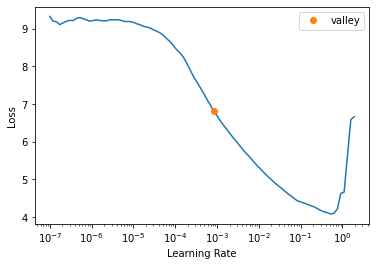

In [ ]:
dls = get_dls(32, 224)
model = resnet50(pretrained=True)
learn = Learner(dls, model1, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy, F1Score(average='macro')])
lr_valley = learn.lr_find()
print(lr_valley)

In [ ]:
learn.fit_one_cycle(20, lr_max=lr_valley, cbs=[WandbCallback(), SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,6.607522,2.604424,0.781690,0.102933,00:14
1,4.158228,3.172323,0.788732,0.788060,00:12
2,2.968278,2.775708,0.584507,0.546719,00:13
3,2.296937,1.241875,0.943662,0.943109,00:14
4,1.906238,1.768581,0.795775,0.795277,00:14
5,1.650083,1.249439,0.908451,0.908337,00:13
6,1.498762,1.241041,0.922535,0.920057,00:13
7,1.383631,1.188262,0.936620,0.936237,00:13
8,1.295079,1.178760,0.950704,0.949987,00:12
9,1.235915,1.127992,0.964789,0.964491,00:12


WandbCallback was not able to get prediction samples -> list index out of range
Better model found at epoch 0 with valid_loss value: 2.604424476623535.
Better model found at epoch 3 with valid_loss value: 1.2418745756149292.
Better model found at epoch 6 with valid_loss value: 1.2410413026809692.
Better model found at epoch 7 with valid_loss value: 1.188261866569519.
Better model found at epoch 8 with valid_loss value: 1.1787595748901367.
Better model found at epoch 9 with valid_loss value: 1.1279919147491455.
Better model found at epoch 13 with valid_loss value: 1.1203409433364868.


In [ ]:
wandb.finish()

epoch,20
train_loss,1.05327
raw_loss,1.04504
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
_runtime,389
_timestamp,1631542396
_step,339


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▆▃▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
